# 1. Setup

## Importovanje potrebnih biblioteka

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import string
import re
from wordcloud import WordCloud
from collections import Counter
import sys

## Učitavanje podataka

In [3]:
df = pd.read_csv("../data/raw/synthetic_emotions.csv")

print("Shape:", df.shape) # daje broj redova i kolona
print('\n')

print(df.head()) # daje header i prvih 5 redova
print('\n')

print("Vrednosti koje nedostaju:\n ", df.isnull().sum())

Shape: (13970, 2)


                                                text emotion
0  As the sun dipped below the horizon, painting ...    Love
1  As she gazed into her partner's eyes, a warm g...    Love
2  As she gazed into his eyes, her heart fluttere...    Love
3  The warm rays of sunlight filtering through th...    Love
4  Her eyes sparkled with a radiant warmth as she...    Love


Vrednosti koje nedostaju:
  text       0
emotion    0
dtype: int64


Pozivanje ovog dela koda nam pokazuje da ukupno imamo 13970 redova u datasetu i da među njima nema redova u kojima fali jedna od vrednosti kolona.

# 2. Osnovna analiza sirovih podataka

## Distribucija klasa

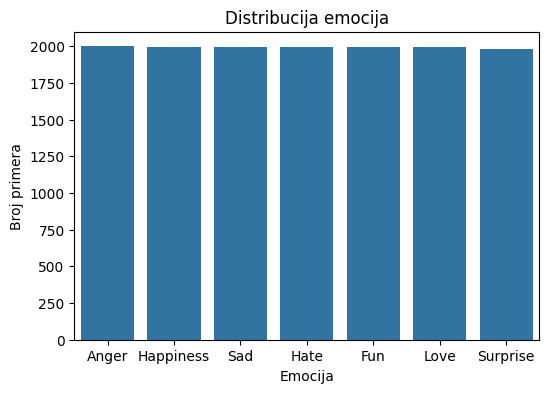

In [4]:
plt.figure(figsize=(6,4))
sb.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)
plt.title("Distribucija emocija")
plt.xlabel("Emocija")
plt.ylabel("Broj primera")
plt.show()

Na osnovu dobijenog grafikona se moeže videti da su emocije tj. klase poprilično jednakih brojeva.

## Dužina tekstova

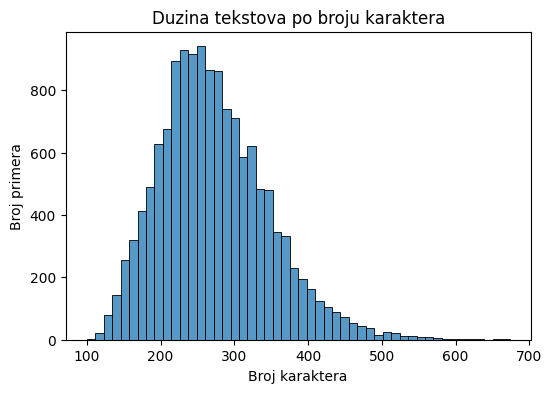

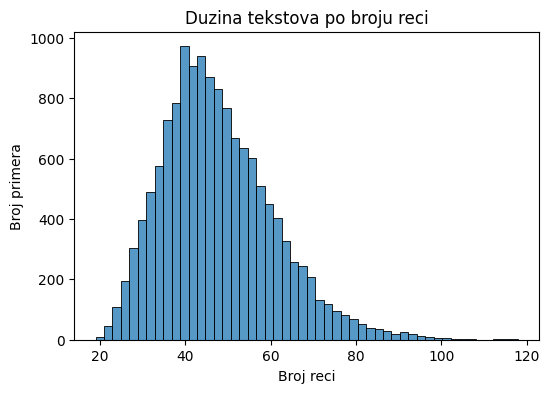

In [ ]:
# duzina u karakterima
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(6,4))
sb.histplot(df['text_length'], bins=50)
plt.title("Duzina tekstova po broju karaktera")
plt.xlabel("Broj karaktera")
plt.ylabel("Broj primera")
plt.show()

# duzina po broju reci
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sb.histplot(df['word_count'], bins=50)
plt.title("Duzina tekstova po broju reci")
plt.xlabel("Broj reci")
plt.ylabel("Broj primera")
plt.show()

Na osnovu dobijenog grafikona koji prikazuje raspodelu redova po broju karaktera, možemo da vidimo relativno normalnu raspodelu gde najviše ima redova dužine od 200 do 300 reči.
Slična situacija je sa grafikonom koji prikazuje raspodelu redova po broju reči, gde takože vidimo normalnu raspodelu gde najviše ima redova dužine od 35 do 55 reči.

## Raspodela dužina po klasi

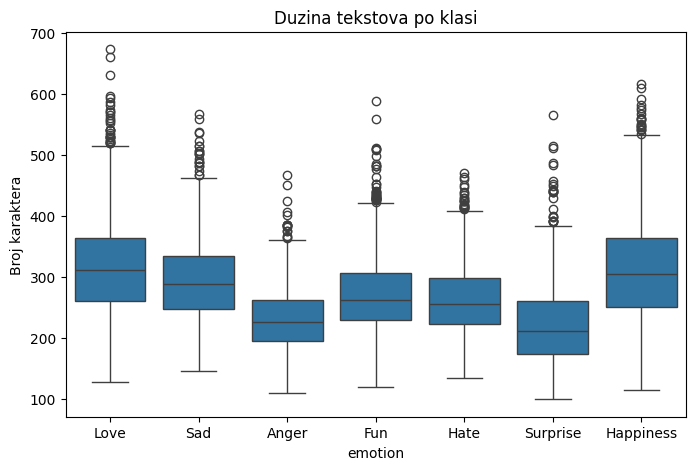

In [6]:
plt.figure(figsize=(8,5))
sb.boxplot(data=df, x='emotion', y='text_length')
plt.title("Duzina tekstova po klasi")
plt.ylabel("Broj karaktera")
plt.show()

Na ovom grafikonu može se videti dužina redova po klasi u broju karaktera, gde se može zapayiti da su najkraći tekstovi koji potpadaju pod Anger, a najduži oni koji potpadaju pod Happines.  

# 3. Provera kvaliteta podataka

## Provera duplikata

In [7]:
print("Dupliktai: ", df.duplicated().sum())

Dupliktai:  3


U celom datasetu postoje tri duplikata.

## Provera specijalnih znakova

In [8]:
def has_special_chars(text):
    return bool(re.search(r'[^a-zA-Z\s]', text))

df['has_special'] = df['text'].apply(has_special_chars)
print("\nImaju specijalne znakove:")
print(df['has_special'].value_counts())


Imaju specijalne znakove:
has_special
True    13970
Name: count, dtype: int64


Možemo da vidimo da svi redovi imaju barem jedan specijalni znak, što je uglavnom zarez. Nećemo ih uklanjati jer pružaju važan kontekst modelu.

## Provera brojeva

In [9]:
def has_numbers(text):
    return any(char.isdigit() for char in text)

df['has_numbers'] = df['text'].apply(has_numbers)
print("\nImaju brojeve:")
print(df['has_numbers'].value_counts())


Imaju brojeve:
has_numbers
False    13963
True         7
Name: count, dtype: int64


Možemo da vidimo da samo 7 redova ima brojeve, što nije značajan broj i ne treba trošiti vreme i resurse na njihovo uklanjanje. 

# 4. Word cloud vizuelizacija

## Najčešće reči po klasi

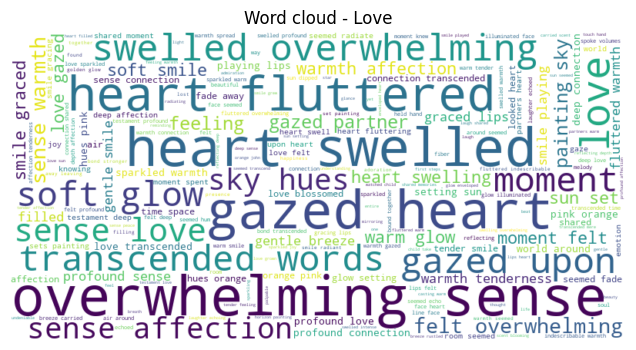

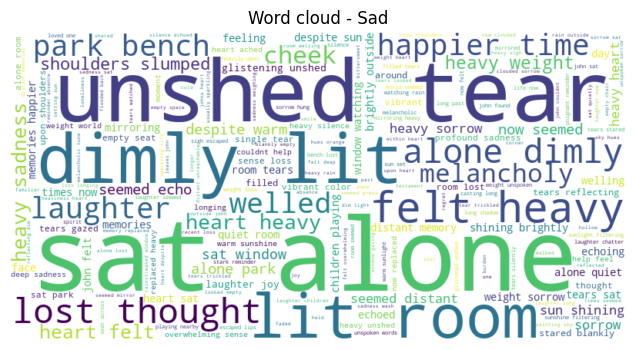

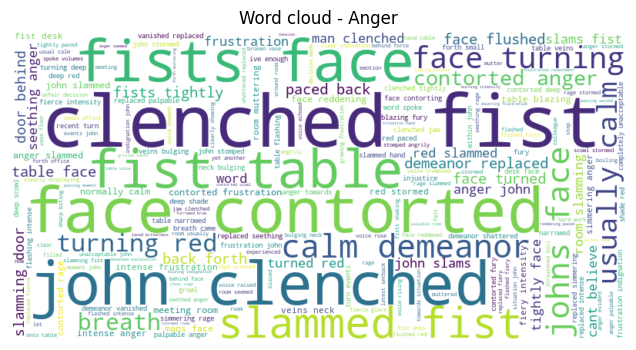

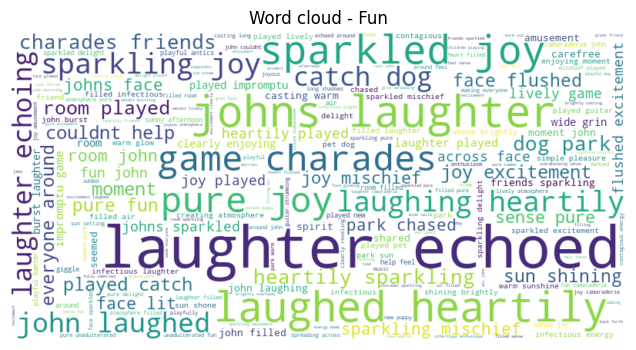

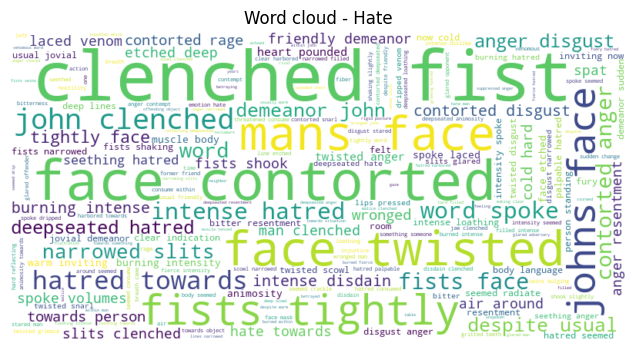

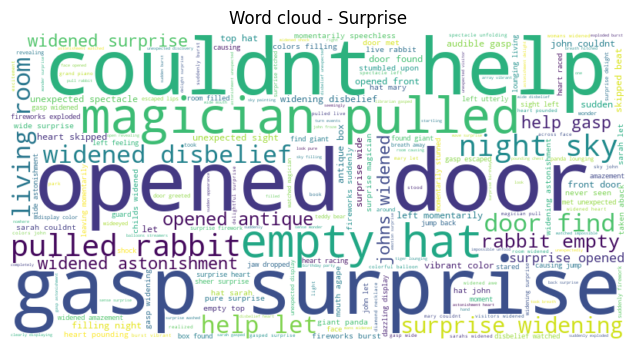

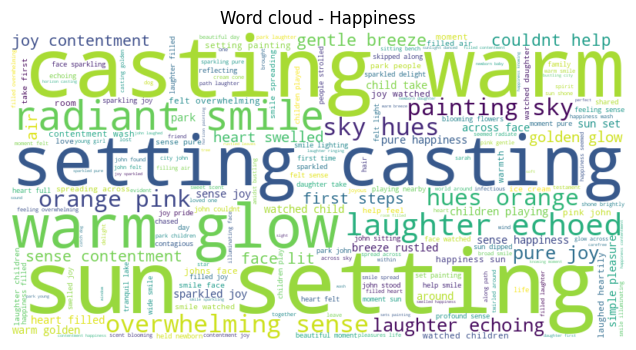

In [10]:
stopwords = set(['the', 'a', 'an', 'and', 'or', 'to', 'of', 'in', 'on', 'for', 'with', 'as', 'by', 'at', 'from', 'that', 'this', 'it', 'he', 'she', 'his', 'her', 
    'they', 'them', 'is', 'was', 'were', 'be', 'been', 'are', 'am', 'but', 'not', 'you', 'i', 'eyes', 'has', 'had', 'him', 'into', 'every'])

def clean_text(texts):
    words = " ".join(texts).lower().split()
    words = [w.translate(str.maketrans('', '', string.punctuation)) for w in words]
    words = [w for w in words if w and w not in stopwords]
    return " ".join(words)

for emotion in df['emotion'].unique():
    text = clean_text(df[df['emotion'] == emotion]['text'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word cloud - {emotion}")
    plt.axis('off')
    plt.show()

Ovaj grafikon je možda najvažniji jer prikazuje najzastupljenije reči po klasi. Ovo je bitno jer će se one koristiti u treniranju modela. Vidimo da su to veoma karakteristične reči, pa zbog toga ćemo kasnije videti da je model veoma uspešan u pogađanju. Pošto se dateset zove synthetic_emotions, veoma je verovatno da je i sam generisan od stane nekog jezičkog modela.

Ovde smo takođe pre pokretanja generisanja grafikona filtrirali neke reči koje same po sebi ne nose neko konkretno značenje, a pojavljuju se najviše u tekstu i u engleskom jeziku generalno (veznici, zamenice, to be i to have glagoli itd.).

# 5. Određivanje max_seq_len

In [11]:
max_seq_len = int(df['word_count'].quantile(0.95))
print("max_seq_len: ", max_seq_len)

max_seq_len:  71


95% tekstova ima do 71 reč, pa je max_seq_len postavljen na 71.
Duži tekstovi će biti skraćeni, a kraći će biti dopunjeni paddingom.

# 6. Pozivanje skripte za preprocesiranje 

In [12]:
sys.path.append('../')
from src.data_preprocessing import DatasetPreprocessor

print("Pokretanje skripte za preprocesiranje...")
preprocessor = DatasetPreprocessor(input_path="../data/raw/synthetic_emotions.csv", output_dir="../data/processed/")
df_cleaned = preprocessor.run_pipeline()

print('\n')
print("Prikaz prvih 5 redova preprocesiranog dataseta koji ide u model:")
display(df_cleaned.head())

Pokretanje skripte za preprocesiranje...
Ucitavanje podataka sa: ../data/raw/synthetic_emotions.csv
Ciscenje podataka...
Uklonjeno duplikata: 3
Enumeracija labela...
Mapiranje labela sacuvano u: ../data/processed/label_mapping.json
Preprocesirani podaci sacuvani u: ../data/processed/emotions_cleaned.csv


Prikaz prvih 5 redova preprocesiranog dataseta koji ide u model:


,text,emotion,label
0,"As the sun dipped below the horizon, painting ...",Love,0
1,"As she gazed into her partner's eyes, a warm g...",Love,0
2,"As she gazed into his eyes, her heart fluttere...",Love,0
3,The warm rays of sunlight filtering through th...,Love,0
4,Her eyes sparkled with a radiant warmth as she...,Love,0
